<a href="https://colab.research.google.com/github/WeAreDobby/CV_project/blob/main/AutoEncoder/AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Google Drive 연동
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from IPython import display

import os
from tqdm import tqdm
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time

In [3]:
# Load Pocketmon Dataset
def find_path(path):
    file_list = os.listdir(path)
    return file_list

def png_to_np(path, file_list, read_type='rgb'):
    pix = []
    for idx in tqdm(range(len(file_list))):
      file_name = file_list[idx]
      if read_type == "rgb":
        image = PIL.Image.open(path + '/' + file_name) # (256, 256, 3)
      elif read_type == "gray":
        image = PIL.Image.open(path + '/' + file_name).convert("L") # (256, 256, 1)
      np_image = (np.array(image).astype(np.float32) - 127.5) / 127.5
      pix.append(np_image)
    return pix

In [68]:
# 포켓몬 데이터셋 받는부분
image_size = 128
channel = 1
read_type = lambda channel: 'rgb' if channel==3 else 'gray'
batch_size = 64
train_size = 10 #768 #616 
test_size =  2  #130 #154 

path = 'drive/MyDrive/dataset/Dobby/Dobby_{}'.format(str(image_size))  # 'drive/MyDrive/dataset/Human/Human_{}'  # 'drive/MyDrive/dataset/pockemon/jpg/jpg_dataset_{}'

file_list = find_path(path)
images = png_to_np(path, file_list, read_type=read_type(channel))

train_dataset = np.array(images[:train_size])
test_dataset = np.array(images[train_size:])

# GrayScale일때 1channel을 만들어주기위해 활용
if channel == 1:
  train_dataset = train_dataset[..., tf.newaxis]
  test_dataset = test_dataset[..., tf.newaxis]

print(train_dataset.shape, test_dataset.shape)

#train_dataset = (tf.data.Dataset.from_tensor_slices(train_dataset)
#                 .shuffle(train_size).batch(batch_size))
#test_dataset = (tf.data.Dataset.from_tensor_slices(test_dataset)
#                .shuffle(test_size).batch(batch_size))

100%|██████████| 12/12 [00:00<00:00, 758.51it/s]

(10, 128, 128, 1) (2, 128, 128, 1)


In [ ]:
# MNIST 데이터셋 받는부분
mnist = tf.keras.datasets.mnist

# (훈련 이미지, 훈련 레이블), (시험 이미지, 시험 레이블)
(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_dataset = x_train[..., tf.newaxis]
test_dataset = x_test[..., tf.newaxis]

#train_dataset = train_dataset.reshape(60000, 784)
#test_dataset = test_dataset.reshape(10000, 784)

# Normal Auto Encoder Architecture

In [98]:
leakyrelu = tf.keras.layers.LeakyReLU()
conv2d = tf.keras.layers.Conv2D
conv2d_t = tf.keras.layers.Conv2DTranspose
flatten = tf.keras.layers.Flatten
dense = tf.keras.layers.Dense
reshape = tf.keras.layers.Reshape

a_input_img = tf.keras.Input(shape=(image_size, image_size, 1))

# encoder
a_encoder1 = conv2d(32, kernel_size=(2, 2), strides=2, activation=leakyrelu, padding="same")(a_input_img)   # 128 -> 64 
a_encoder2 = conv2d(64, kernel_size=(2, 2), strides=2, activation=leakyrelu, padding="same")(a_encoder1)    # 64 -> 32
#encoder3 = conv2d(128, kernel_size=(2, 2), strides=2, activation=leakyrelu, padding="same")(encoder2)   # 32 -> 16  
#encoder4 = conv2d(256, kernel_size=(2, 2), strides=2, activation=leakyrelu, padding="same")(encoder3)   # 16 -> 8

a_flatten = flatten()(a_encoder2)
a_dense1 = dense(10, activation=leakyrelu)(a_flatten)
a_dense2 = dense(int(image_size/4) * int(image_size/4) * 64, activation=leakyrelu)(a_dense1)
#dense3 = dense(8 * 8 * 256, activation='sigmoid')(dense2)
#dense4 = dense(8 * 8 * 256, activation='sigmoid')(dense3)

a_reshape = reshape(target_shape=(int(image_size/4), int(image_size/4), 64), input_shape=(a_dense2,))(a_dense2)
# decoder
#decoder1 = conv2d_t(128, kernel_size=(2, 2), strides=2, activation=leakyrelu, padding="same")(encoder4) 
#decoder2 = conv2d_t(64, kernel_size=(2, 2), strides=2, activation=leakyrelu, padding="same")(decoder1) 
a_decoder1 = conv2d_t(32, kernel_size=(2, 2), strides=2, activation=leakyrelu, padding="same")(a_reshape)
a_decoder2 = conv2d_t(1, kernel_size=(2, 2), strides=2, padding="same")(a_decoder1)

autoencoder = tf.keras.Model(inputs=a_input_img, outputs=a_decoder2)

In [99]:
leakyrelu = tf.keras.layers.LeakyReLU()
conv2d = tf.keras.layers.Conv2D
conv2d_t = tf.keras.layers.Conv2DTranspose
flatten = tf.keras.layers.Flatten
dense = tf.keras.layers.Dense
reshape = tf.keras.layers.Reshape

g_input_img = tf.keras.Input(shape=(image_size, image_size, 1))

# encoder
g_encoder1 = conv2d(32, kernel_size=(2, 2), strides=2, activation=leakyrelu, padding="same")(g_input_img)
g_encoder2 = conv2d(64, kernel_size=(2, 2), strides=2, activation=leakyrelu, padding="same")(g_encoder1)

g_decoder1 = conv2d_t(32, kernel_size=(2, 2), strides=2, activation=leakyrelu, padding="same")(g_encoder2)
g_decoder2 = conv2d_t(1, kernel_size=(2, 2), strides=2, padding="same")(g_decoder1)

generator = tf.keras.Model(inputs=g_input_img, outputs=g_decoder2)

In [100]:
autoencoder.summary(), generator.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 64, 32)        160       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 64)        8256      
_________________________________________________________________
flatten (Flatten)            (None, 65536)             0         
_________________________________________________________________
dense (Dense)                (None, 10)                655370    
_________________________________________________________________
dense_1 (Dense)              (None, 65536)             720896    
_________________________________________________________________
reshape (Reshape)            (None, 32, 32, 64)        0   

(None, None)

In [101]:
autoencoder.compile(optimizer='adam', loss='MSE')
autoencoder.fit(train_dataset, train_dataset,
                epochs=50,
                batch_size=64,
                shuffle=True,
                validation_data=(test_dataset, test_dataset))

print('auto encoder train finish')

generator.compile(optimizer='adam', loss='MSE')
generator.fit(train_dataset, train_dataset,
              epochs=50,
              batch_size=64,
              shuffle=True,
              validation_data=(test_dataset, test_dataset))

print('generator train finish')

Epoch 1/50
1/1 [==============================] - 1s 584ms/step - loss: 0.1376 - val_loss: 0.0890
Epoch 2/50
1/1 [==============================] - 0s 24ms/step - loss: 0.1362 - val_loss: 0.0879
Epoch 3/50
1/1 [==============================] - 0s 22ms/step - loss: 0.1347 - val_loss: 0.0867
Epoch 4/50
1/1 [==============================] - 0s 21ms/step - loss: 0.1331 - val_loss: 0.0853
Epoch 5/50
1/1 [==============================] - 0s 21ms/step - loss: 0.1312 - val_loss: 0.0835
Epoch 6/50
1/1 [==============================] - 0s 23ms/step - loss: 0.1284 - val_loss: 0.0809
Epoch 7/50
1/1 [==============================] - 0s 22ms/step - loss: 0.1240 - val_loss: 0.0768
Epoch 8/50
1/1 [==============================] - 0s 22ms/step - loss: 0.1170 - val_loss: 0.0706
Epoch 9/50
1/1 [==============================] - 0s 21ms/step - loss: 0.1060 - val_loss: 0.0616
Epoch 10/50
1/1 [==============================] - 0s 22ms/step - loss: 0.0899 - val_loss: 0.0504
Epoch 11/50
1/1 [===========

In [74]:
# Noise 생성부
noises = []

for i in range(test_size):
  noise = tf.random.normal((image_size, image_size), mean=0.0, stddev=1.0, dtype=tf.dtypes.float32, seed=None, name=None) 
  noise = noise[..., tf.newaxis]
  noises.append(noise)

noises = np.array(noises)

print(noises.shape)

(2, 128, 128, 1)


In [102]:
import random
# 13개의 난수 생성
randoms = []
for i in range(160):
  random_value = random.randint(0, image_size ** 2)
  randoms.append(random_value)
print(randoms)

# test Dataset을 활용하여 Feature Map 추출
reconstructed_imgs = autoencoder.predict(test_dataset)
reconstructed_imgs.shape
noisealization_imgs = []

# 추출된 FeatureMap에 Noise를 넣어줌
for image in reconstructed_imgs:
  # 1차원으로 reshpae
  image = tf.reshape(image, (-1, 1))
  image = image.numpy()
  print(min(image), max(image))

  # 1차원으로 reshape된 이미지에 난수와 동일한 index를 만나면 해당값을 Random값으로 변환
  for idx, i in enumerate(image):
    if idx in randoms:
      ranfloat = random.uniform(0., 1.0)
      image[idx] = ranfloat

  # Noise가 섞인 이미지는 다시 원래 사이즈로 돌려놓고 새로운 리스트에 넣어줌
  image = image.reshape(image_size, image_size, 1)
  noisealization_imgs.append(image)

# 기존 shape와 동일하게 나옴
noisealization_imgs = np.array(noisealization_imgs)
print(noisealization_imgs.shape)

predict_imgs = generator.predict(noisealization_imgs)

if channel == 3:
  reconstructed_imgs = (np.array(reconstructed_imgs) * 255).astype(np.int64)

[11396, 3931, 38, 10778, 13508, 9252, 13308, 15387, 10579, 16071, 10995, 3686, 8210, 7134, 360, 3534, 12859, 7782, 3237, 1648, 5306, 9703, 14226, 13194, 4093, 7865, 14138, 8758, 7949, 8019, 3627, 4356, 14276, 1856, 4067, 1958, 10753, 8022, 10168, 11495, 2126, 9230, 11917, 13622, 11191, 1881, 10869, 13159, 1559, 9556, 7388, 8996, 16351, 11316, 3204, 12868, 7556, 2362, 10863, 6177, 1885, 12619, 4820, 11897, 9728, 3575, 12612, 4773, 8383, 3526, 5930, 8558, 7446, 14329, 6132, 5738, 9942, 582, 8678, 7126, 886, 8722, 1470, 7064, 15407, 15529, 2521, 9874, 9765, 7582, 7147, 12209, 13682, 13965, 7248, 7542, 5187, 13072, 5571, 11401, 576, 15088, 1034, 5559, 906, 13458, 8969, 5777, 1640, 6479, 2409, 705, 5829, 7722, 7909, 3092, 8619, 10983, 11116, 963, 2069, 3998, 3250, 1027, 5570, 14051, 4543, 559, 3623, 15380, 10023, 6603, 16224, 2809, 11697, 3157, 3459, 1239, 3547, 1197, 2619, 5126, 9022, 2606, 11299, 6448, 10727, 15394, 6426, 2680, 6684, 13073, 13184, 14869, 10842, 6513, 15935, 14049, 15642, 

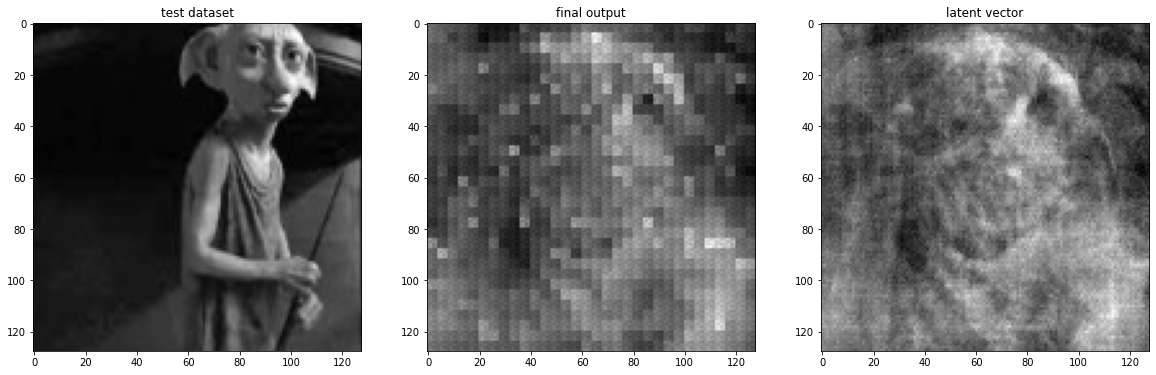

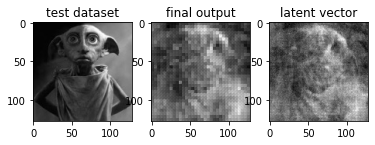

In [103]:
rgb_size = (image_size, image_size, 3)
gray_size = (image_size, image_size)
epochs = 2  # how many digits we will display

plt.figure(figsize=(20, 20))
for i in range(epochs):
    plt.subplot(131)
    plt.title('test dataset')
    # display original
    if channel == 1:
      plt.imshow(test_dataset[i].reshape(gray_size), cmap='gray')
    else:
      plt.imshow(test_dataset[i].reshape(rgb_size))

    plt.subplot(132)
    plt.title('final output')
    # display original
    if channel == 1:
      plt.imshow(predict_imgs[i].reshape(gray_size), cmap='gray')
    else:
      plt.imshow(predict_imgs[i].reshape(rgb_size))

    # display reconstructed image
    plt.subplot(133)
    plt.title('latent vector')
    if channel == 1:
      plt.imshow(reconstructed_imgs[i].reshape(gray_size), cmap='gray')
    else:
      plt.imshow(reconstructed_imgs[i].reshape(rgb_size))
    plt.show()

Encoder 2Layers => 32, 32, 64  
Flatten or Resize => Noise Size와 동일한 사이즈로 reshape  
reshape된 FeatureMap을 Noise와 결합  
  
결합된 Noise를 Flatten 하여 Dense를 통해 (32 * 32 * 64)로 변환  
(32, 32, 64)로 reshape를 진행후 conv2d_t를 통해 원본 Image사이즈로 복귀